Get the closest shoreline point on NDWI Satellite images based on given geocoordinates! 

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pip install sentinelhub
!pip install rasterio
!pip install sentinelhub shapely
!pip install numpy
!pip install geopy

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
sentinel_client_id = user_secrets.get_secret("sentinel_client_id")
sentinel_client_secret = user_secrets.get_secret("sentinel_client_secret")
sentinel_id = user_secrets.get_secret("sentinel_id")

# Configuration for SentinelHub
from sentinelhub import SHConfig
config = SHConfig()
config.instance_id = sentinel_id
config.sh_client_id = sentinel_client_id
config.sh_client_secret = sentinel_client_secret

In [11]:
import numpy as np
from shapely.geometry import Point

def find_local_minimum(distance_transform, point_pixel, window_size=3):
    # get size of the window
    if window_size % 2 == 0:
        raise ValueError("not a good value")

    # create window
    half_window = window_size // 2
    row_start, row_end = max(0, point_pixel[0] - half_window), min(distance_transform.shape[0], point_pixel[0] + half_window + 1)
    col_start, col_end = max(0, point_pixel[1] - half_window), min(distance_transform.shape[1], point_pixel[1] + half_window + 1)
    window = distance_transform[row_start:row_end, col_start:col_end]

    # local minimum
    if np.all(window >= window[half_window, half_window]):
        return point_pixel
    else:
        # if there is no local minimum get a larger window
        return None

In [12]:
def get_pixel_from_geo(ndwi_image, lat, lon, bbox):
    """
    turn geocoordinate to pixel coordinate
    """
    min_x, min_y, max_x, max_y = bbox
    pixel_x = int((lon - min_x) / (max_x - min_x) * ndwi_image.shape[1])
    pixel_y = int((max_y - lat) / (max_y - min_y) * ndwi_image.shape[0])
    return (pixel_y, pixel_x)

In [13]:
# Function to calculate NDWI and visualize the image
def get_and_visualize_ndwi(bbox, title):
    # Sentinel Hub evalscript for NDWI calculation
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B08", "B02"],
            output: { bands: 1 }
        };
    }

    function evaluatePixel(sample) {
        // Calculate NDWI
        const ndwi = (sample.B08 - sample.B02) / (sample.B08 + sample.B02);
        return [ndwi];
    }
    """

    # Create Sentinel Hub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )

    # Get data from Sentinel Hub
    response = request.get_data()
    ndwi_image = response[0]

    # Clip and normalize NDWI values
    ndwi_image = np.clip(ndwi_image, -1, 1)  # Ensure NDWI values are within valid range
    normalized_image = (ndwi_image - ndwi_image.min()) / (ndwi_image.max() - ndwi_image.min())

    # Visualize NDWI image
    plt.imshow(normalized_image, cmap='coolwarm')
    plt.title(title)
    plt.colorbar(label='NDWI')
    plt.axis('off')
    plt.show()
    return normalized_image

In [21]:
# Function to convert geographic coordinates to pixel coordinates
def geo_to_pixel(geo, bbox, image_shape):
    lat, lon = geo
    height, width = image_shape
    min_lon, min_lat, max_lon, max_lat = bbox
    x = int((lon - min_lon) / (max_lon - min_lon) * width)
    y = int((max_lat - lat) / (max_lat - min_lat) * height)
    return x, y

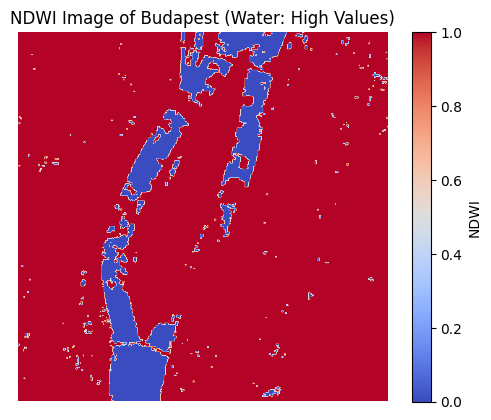

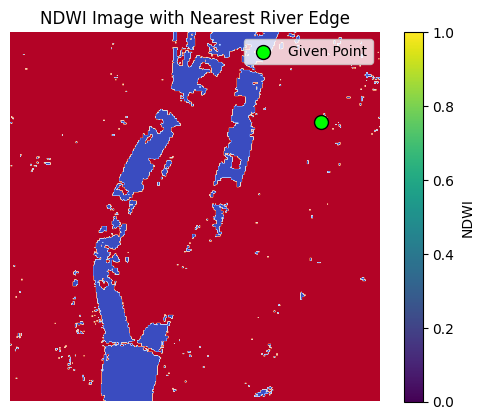

In [25]:
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox
import matplotlib.pyplot as plt
import numpy as np

bbox = BBox(bbox=[19.03, 47.51, 19.07, 47.54], crs=CRS.WGS84)
ndwi_image = get_and_visualize_ndwi(bbox, 'NDWI Image of Budapest (Water: High Values)')
geo_point = (47.51471344556954, 19.039797903345697)
point_pixel = get_pixel_from_geo(ndwi_image, 47.51471344556954, 19.039797903345697, bbox)
result = find_local_minimum(ndwi_image, point_pixel, window_size=3)

pixel_point = geo_to_pixel(geo_point, bbox, ndwi_image.shape)
plt.imshow(ndwi_image, cmap='coolwarm')
plt.scatter(*pixel_point[::-1], color='lime', s=100, edgecolor='black', label='Given Point')
#plt.scatter(*result[::-1], color='green', s=100, edgecolor='black', label='Nearest River Edge')
plt.title('NDWI Image with Nearest River Edge')
plt.colorbar(label='NDWI')
plt.axis('off')
plt.legend()
plt.show()

In [24]:
result

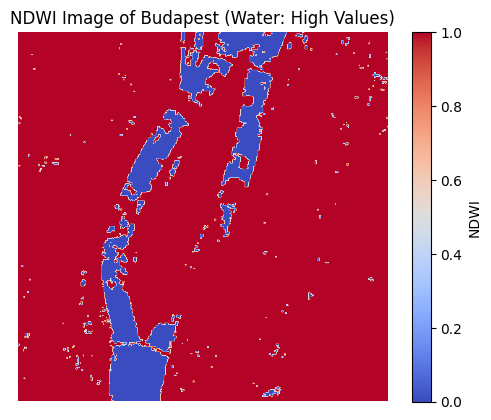

The nearest river edge to the point (47.51471344556954, 19.039797903345697) is at (47.54, 19.03).


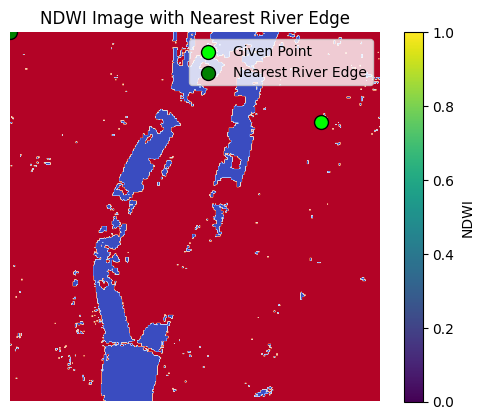

In [26]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from sentinelhub import BBox, CRS, DataCollection, SentinelHubRequest, MimeType

# Set coordinates (Budapest area)
bbox = BBox(bbox=[19.03, 47.51, 19.07, 47.54], crs=CRS.WGS84)

# Function to calculate NDWI and visualize the image
def get_and_visualize_ndwi(bbox, title):
    # Sentinel Hub evalscript for NDWI calculation
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B08", "B02"],
            output: { bands: 1 }
        };
    }

    function evaluatePixel(sample) {
        // Calculate NDWI
        const ndwi = (sample.B08 - sample.B02) / (sample.B08 + sample.B02);
        return [ndwi];
    }
    """

    # Create Sentinel Hub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )

    # Get data from Sentinel Hub
    response = request.get_data()
    ndwi_image = response[0]

    # Clip and normalize NDWI values
    ndwi_image = np.clip(ndwi_image, -1, 1)  # Ensure NDWI values are within valid range
    normalized_image = (ndwi_image - ndwi_image.min()) / (ndwi_image.max() - ndwi_image.min())

    # Visualize NDWI image
    plt.imshow(normalized_image, cmap='coolwarm')
    plt.title(title)
    plt.colorbar(label='NDWI')
    plt.axis('off')
    plt.show()

    return normalized_image

# Get and visualize NDWI image
ndwi_image = get_and_visualize_ndwi(bbox, 'NDWI Image of Budapest (Water: High Values)')

# Function to convert geographic coordinates to pixel coordinates
def geo_to_pixel(geo, bbox, image_shape):
    lat, lon = geo
    height, width = image_shape
    min_lon, min_lat, max_lon, max_lat = bbox
    x = int((lon - min_lon) / (max_lon - min_lon) * width)
    y = int((max_lat - lat) / (max_lat - min_lat) * height)
    return x, y

# Function to find the nearest river edge to a given geographic coordinate on the NDWI image
def find_nearest_river_edge(ndwi_image, geo_point, bbox):
    # Convert geographic coordinate to pixel coordinate
    pixel_point = geo_to_pixel(geo_point, bbox, ndwi_image.shape)

    # Create a binary mask where water pixels are 1 and non-water pixels are 0
    water_mask = ndwi_image > 3

    # Compute the distance transform of the binary mask
    distance_transform = distance_transform_edt(~water_mask)

    # Find the nearest water edge pixel to the given point
    nearest_edge_pixel = np.unravel_index(np.argmin(distance_transform[pixel_point[1], pixel_point[0]]), distance_transform.shape)

    # Convert the nearest edge pixel back to geographic coordinates
    height, width = ndwi_image.shape
    min_lon, min_lat, max_lon, max_lat = bbox

    nearest_edge_geo = (
        max_lat - (nearest_edge_pixel[0] / height) * (max_lat - min_lat),
        min_lon + (nearest_edge_pixel[1] / width) * (max_lon - min_lon)
    )

    return nearest_edge_geo, nearest_edge_pixel

# Example geographic coordinate for measurement
geo_point = (47.51471344556954, 19.039797903345697)

# Find the nearest river edge to the given geographic coordinate
nearest_river_edge_geo, nearest_edge_pixel = find_nearest_river_edge(ndwi_image, geo_point, bbox)
print(f"The nearest river edge to the point {geo_point} is at {nearest_river_edge_geo}.")

# Visualize the result on the NDWI image
pixel_point = geo_to_pixel(geo_point, bbox, ndwi_image.shape)
plt.imshow(ndwi_image, cmap='coolwarm')
plt.scatter(*pixel_point[::-1], color='lime', s=100, edgecolor='black', label='Given Point')
plt.scatter(*nearest_edge_pixel[::-1], color='green', s=100, edgecolor='black', label='Nearest River Edge')
plt.title('NDWI Image with Nearest River Edge')
plt.colorbar(label='NDWI')
plt.axis('off')
plt.legend()
plt.show()
